# Music Recommendation App

## Load Libraries

In [201]:
from __future__ import print_function
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import sys
import logging
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score



## Scrape Hot 100 Billboard

In [54]:
url = "https://www.billboard.com/charts/hot-100"
text = requests.get(url).text
soup = BeautifulSoup(text,  parser="html5lib")

In [55]:
chart_list = soup.findAll("span", {"class": "chart-element__information__song"})

In [56]:
songs_list = []
for i in chart_list:
    # print (i.text)
    songs_list.append(i.text)

In [57]:
data = {'Song': [], 
        'Artist': []} 

top_songs = pd.DataFrame(data)

top_songs['Song'] = songs_list

In [58]:
artist_list = soup.findAll("span", {"class": "chart-element__information__artist"})

artists = []
for artist in artist_list:
    artists.append(artist.text)
    
top_songs['Artist'] = artists
top_songs.head(20)

,Song,Artist
0,Life Goes On,BTS
1,Mood,24kGoldn Featuring iann dior
2,Dynamite,BTS
3,Positions,Ariana Grande
4,I Hope,Gabby Barrett Featuring Charlie Puth
5,Holy,Justin Bieber Featuring Chance The Rapper
6,Laugh Now Cry Later,Drake Featuring Lil Durk
7,Monster,Shawn Mendes & Justin Bieber
8,Blinding Lights,The Weeknd
9,Lemonade,Internet Money & Gunna Featuring Don Toliver &...


## Scrape Rolling Stone 500 Greatest Songs of All Time - Multiple Pages

In [59]:
rolling_list = pd.DataFrame(columns=['#', 'Name', 'Artist', 'ISRCs', 'Rating', 'Length'])
nums = ['1','2','3','4','5']
for i in range(5):
    url = "https://musicbrainz.org/series/b3484a66-a4de-444d-93d3-c99a73656905?page=" + nums[i]
    page_data = pd.read_html(url)
    table = page_data[0]
    rolling_list = rolling_list.append(table)

rolling_list = rolling_list.reset_index(drop=True)
rolling_list


,#,Name,Artist,ISRCs,Rating,Length
0,1,Like a Rolling Stone,Bob Dylan,NaN,NaN,6:11
1,2,(I Can’t Get No) Satisfaction (live: Royal Alb...,The Rolling Stones,USA176610240,NaN,3:05
2,3,Imagine (original studio mix),John Lennon,GBAYE0000028GBAYE1000769GBAYE7100010,4.50,3:04
3,4,What’s Going On (original LP version),Marvin Gaye,USMO10000523USMO17100041USMO19290028,4.40,3:53
4,5,Respect,Aretha Franklin,DELJ81808923USAT20102330USAT20302295USAT205044...,4.00,2:26
...,...,...,...,...,...,...
495,496,Miss You,The Rolling Stones,GBCJN7800001,4.15,4:49
496,497,Buddy Holly,Weezer,USGF19562907,4.35,2:40
497,498,Rainy Night in Georgia,Brook Benton,NaN,4.00,3:51
498,499,The Boys Are Back In Town,Thin Lizzy,NaN,NaN,4:25


## Using Spotify Data

In [60]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="9631e558f1ac4f48a1433400087d6df1",
                                                           client_secret="856733e90c3a4e76ab3cec4aee59f989"))

#Test with a simple search

results = sp.search(q='Drake', limit=20)
for idx, track in enumerate(results['tracks']['items']):
    print(idx, track['name'])

0 Laugh Now Cry Later (feat. Lil Durk)
1 POPSTAR (feat. Drake)
2 Life Is Good (feat. Drake)
3 GREECE (feat. Drake)
4 No Guidance (feat. Drake)
5 Chicago Freestyle (feat. Giveon)
6 Going Bad (feat. Drake)
7 Money In The Grave (Drake ft. Rick Ross)
8 Yes Indeed
9 Toosie Slide
10 God's Plan
11 Nonstop
12 Drama (feat. Drake)
13 Girls Need Love (with Drake) - Remix
14 Passionfruit
15 Nice For What
16 You’re Mines Still (feat. Drake)
17 Drake
18 B.B. King Freestyle (with Drake)
19 MIA (feat. Drake)


In [136]:
# Finding some playlists
playlist_id_list = []
playlists = sp.user_playlists('spotify')
while playlists:
    for i, playlist in enumerate(playlists['items']):
        # print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
        playlist_id_list.append(playlist['uri'])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

In [9]:
#function to get tracks from playlist 

def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [10]:
tracks = get_playlist_tracks("37i9dQZF1DXcBWIGoYBM5M")

In [11]:
#Test with long playlist
# long_test = get_playlist_tracks("6yPiKpy7evrwvZodByKvM9")
# len(long_test)

In [12]:
playlist_df = pd.DataFrame(tracks)

In [13]:
playlist_tracks = playlist_df['track']

In [14]:
len(playlist_tracks)

50

## Find artists, title and song features.

In [15]:
playlist_tracks[0]['album']['artists'][0]['name']

'Bad Bunny'

In [16]:
playlist_tracks[0]['album']['artists'][1]['name']

# This song has two artist.

'Jhay Cortez'

In [17]:
playlist_tracks[0]['name']

#Track Title

'Dakiti'

In [18]:
playlist_tracks[0]['id']


'47EiUVwUp4C9fGccaPuUCS'

In [19]:
playlist_tracks[0]['album']['external_urls']

{'spotify': 'https://open.spotify.com/album/43dl8hP5uNN9s6YeeJA5fv'}

In [20]:
sp.audio_features('47EiUVwUp4C9fGccaPuUCS')[0]


{'danceability': 0.731,
 'energy': 0.573,
 'key': 4,
 'loudness': -10.059,
 'mode': 0,
 'speechiness': 0.0544,
 'acousticness': 0.401,
 'instrumentalness': 5.22e-05,
 'liveness': 0.113,
 'valence': 0.145,
 'tempo': 109.928,
 'type': 'audio_features',
 'id': '47EiUVwUp4C9fGccaPuUCS',
 'uri': 'spotify:track:47EiUVwUp4C9fGccaPuUCS',
 'track_href': 'https://api.spotify.com/v1/tracks/47EiUVwUp4C9fGccaPuUCS',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/47EiUVwUp4C9fGccaPuUCS',
 'duration_ms': 205090,
 'time_signature': 4}

In [21]:
def scrape_playlist_data(playlist_name):
    
    df = pd.DataFrame(columns=['Track_artist','Track_title','Track_ID','danceability','energy','key',
                               'loudness','mode','speechiness','acousticness','instrumentalness',
                               'liveness','valence','tempo'])
    
    #for i in range(2):
    for i in range(len(playlist_name)):
        # print('Test')
        if len(playlist_name[i]['album']['artists']) == 1:
            track_artist = playlist_name[i]['album']['artists'][0]['name']
        else:
            track_artist = playlist_name[i]['album']['artists'][0]['name'] + ", " + playlist_name[i]['album']['artists'][1]['name']
        #print(track_artist)
        track_title = playlist_name[i]['name']
        track_id = playlist_name[i]['id']
        
        track_features = sp.audio_features(track_id)
        
        track_features = track_features[0]
        danceability = track_features['danceability']
        energy = track_features['energy']
        key = track_features['key']
        loudness = track_features['loudness']
        mode = track_features['mode']
        speechiness = track_features['speechiness']
        acousticness = track_features['acousticness']
        instrumentalness = track_features['instrumentalness']
        liveness = track_features['liveness']
        valence = track_features['valence']
        tempo = track_features['tempo']
        # print(energy)
        list = [track_artist,track_title, track_id,danceability,energy,key,loudness,mode,speechiness,
                acousticness,instrumentalness,liveness,valence,tempo]
        a_series = pd.Series(list, index = df.columns)
        df = df.append(a_series, ignore_index=True)
    return df

In [22]:
todays_top_hits = scrape_playlist_data(playlist_tracks)

In [103]:
todays_top_hits.head()

,Track_artist,Track_title,Track_ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,"Bad Bunny, Jhay Cortez",Dakiti,47EiUVwUp4C9fGccaPuUCS,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928
1,"Miley Cyrus, Dua Lipa",Prisoner (feat. Dua Lipa),5JqZ3oqF00jkT81foAFvqg,0.781,0.670,3,-3.912,0,0.0452,0.01030,0.000000,0.0761,0.595,127.990
2,Ariana Grande,positions,7igeByaBM0MgGsgXtNxDJ7,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.000000,0.0940,0.675,144.005
3,Billie Eilish,Therefore I Am,54bFM56PmE4YLRnqpW6Tha,0.889,0.340,11,-7.773,0,0.0697,0.21800,0.130000,0.0550,0.716,94.009
4,The Weeknd,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005


## Cool, all working. Now to get lots of playlists

In [24]:
top_country = get_playlist_tracks("37i9dQZF1DX1lVhptIYRda")

In [25]:
len(top_country)

53

In [26]:
top_country_df = pd.DataFrame(top_country)

In [27]:
top_country_tracks =top_country_df['track']

In [102]:
top_country_songs = scrape_playlist_data(top_country_tracks)
#top_country_songs

## Now to try and automate the process a bit better.

In [29]:
def playlist_id_to_song_dataframe(playlist_id):
    data_from_playlist = get_playlist_tracks(playlist_id)
    data_as_df = pd.DataFrame(data_from_playlist)
    just_track_data =data_as_df['track']
    data_to_output = scrape_playlist_data(just_track_data)
    return data_to_output

In [39]:
hits1990 = playlist_id_to_song_dataframe('37i9dQZF1DXbTxeAdrVG2l')

In [ ]:
playlist_id_to_song_dataframe('37i9dQZF1E4wQfN05DG7qu')

In [37]:
dnb = playlist_id_to_song_dataframe('5XGbuIRSb5INv66b817DJH') # Drum and Bass

In [101]:
my_berlin_playlist = playlist_id_to_song_dataframe('6J9XAhewFcfCIO2f2w0qkL')
#my_berlin_playlist

In [ ]:
#bigger_playlist = playlist_id_to_song_dataframe('6J9XAhewFcfCIO2f2w0qkL')
#bigger_playlist

In [34]:
playlist_id_list[0].strip('spotify:playlist:')

'37i9dQZF1DXcBWIGoYBM5M'

In [35]:
just_ids = []
for item in playlist_id_list:
    just_ids.append(item.strip('spotify:playlist:'))

In [100]:
#just_ids

In [43]:
big_song_list = my_berlin_playlist.append([todays_top_hits,top_country_songs,dnb,hits1990])

In [44]:
big_song_list = big_song_list.reset_index(drop=True)

In [99]:
#big_song_list

In [47]:
more_songs = pd.DataFrame(columns=['Track_artist','Track_title','Track_ID','danceability','energy','key',
                               'loudness','mode','speechiness','acousticness','instrumentalness',
                               'liveness','valence','tempo'])

In [50]:
#for i in range(1,10):
#    more_songs.append(playlist_id_to_song_dataframe(just_ids[i]))


In [62]:
piano = playlist_id_to_song_dataframe('37i9dQZF1DX4sWSpwq3LiO')

In [63]:
more_songs = more_songs.append(piano)

In [64]:
rockclassics = playlist_id_to_song_dataframe('37i9dQZF1DWXRqgorJj26U')

In [65]:
more_songs = more_songs.append(rockclassics)

In [66]:
dancehall = playlist_id_to_song_dataframe('37i9dQZF1DXan38dNVDdl4')
more_songs = more_songs.append(dancehall)

In [67]:
hip_hop = playlist_id_to_song_dataframe('37i9dQZF1DXaKctwWdt4be')
more_songs = more_songs.append(hip_hop)

In [68]:
alternativebeats = playlist_id_to_song_dataframe('37i9dQZF1DWXMg4uP5o3dm')
more_songs = more_songs.append(alternativebeats)

In [69]:
funk = playlist_id_to_song_dataframe('37i9dQZF1DX70TzPK5buVf')
more_songs = more_songs.append(funk)


In [70]:
classical = playlist_id_to_song_dataframe('37i9dQZF1DXbaZdHeCwl9C')
more_songs = more_songs.append(classical)


In [71]:
jazzvibes = playlist_id_to_song_dataframe('37i9dQZF1DX0SM0LYsmbMT')
more_songs = more_songs.append(jazzvibes)


In [72]:
lofi_house = playlist_id_to_song_dataframe('37i9dQZF1DXbXD9pMSZomS')
more_songs = more_songs.append(lofi_house)


In [73]:
footwerkz = playlist_id_to_song_dataframe('37i9dQZF1DX3nNRJvSufrk')
more_songs = more_songs.append(footwerkz)

In [98]:
#footwerkz.sort_values(by=['energy'], ascending=False)

In [77]:
more_songs = more_songs.reset_index(drop=True)

In [86]:
big_song_list = big_song_list.append(more_songs)
big_song_list = big_song_list.reset_index(drop=True)
big_song_list

In [85]:
#big_song_list.sort_values(by=['danceability'], ascending=False)

In [88]:
shower = playlist_id_to_song_dataframe('5LtwydYUv9Um4D2toY3Wzh')
big_song_list = big_song_list.append(shower)

In [89]:
vintagefolk = playlist_id_to_song_dataframe('6zcjhNUkQ6taQK9hxhweCj')
big_song_list = big_song_list.append(vintagefolk)

In [90]:
indieballads = playlist_id_to_song_dataframe('0aXP5u51kHZiKvxkUPq0IL')
big_song_list = big_song_list.append(indieballads)

In [91]:
barista = playlist_id_to_song_dataframe('25zEHXJzEQZU1eyF6eqEzD')
big_song_list = big_song_list.append(barista)

In [92]:
relax = playlist_id_to_song_dataframe('37i9dQZF1DWU0ScTcjJBdj')
big_song_list = big_song_list.append(relax)

In [93]:
carsongs = playlist_id_to_song_dataframe('37i9dQZF1DWWMOmoXKqHTD')
big_song_list = big_song_list.append(carsongs)

In [94]:
americana = playlist_id_to_song_dataframe('37i9dQZF1DX7tfbjVrTPnV')
big_song_list = big_song_list.append(americana)

In [95]:
swagger = playlist_id_to_song_dataframe('37i9dQZF1DWSlw12ofHcMM')
big_song_list = big_song_list.append(swagger)

In [96]:
big_song_list = big_song_list.reset_index(drop=True)

In [105]:
popgaming = playlist_id_to_song_dataframe('37i9dQZF1DWYRNXjFoiid2')
big_song_list = big_song_list.append(popgaming)

In [106]:
breadanddub = playlist_id_to_song_dataframe('4drXxn0GpOXXG6Rp5RvXca')
big_song_list = big_song_list.append(breadanddub)

In [107]:
bluesskies = playlist_id_to_song_dataframe('070FVPBKvfu6M5tf4I9rt2')
big_song_list = big_song_list.append(bluesskies)

In [108]:
ibizasunset = playlist_id_to_song_dataframe('37i9dQZF1DX9FIMhEujaK6')
big_song_list = big_song_list.append(ibizasunset)

In [109]:
carefree = playlist_id_to_song_dataframe('37i9dQZF1DWVQLL1sym9rG')
big_song_list = big_song_list.append(carefree)

In [110]:
confidence = playlist_id_to_song_dataframe('37i9dQZF1DX4fpCWaHOned')
big_song_list = big_song_list.append(confidence)

In [111]:
happydrive = playlist_id_to_song_dataframe('37i9dQZF1DX1WSnLRtI26o')
big_song_list = big_song_list.append(happydrive)

In [112]:
parkhangs = playlist_id_to_song_dataframe('37i9dQZF1DWSP55jZj2ES3')
big_song_list = big_song_list.append(parkhangs)

In [116]:
big_song_list = big_song_list.reset_index(drop=True)
#big_song_list

In [255]:
big_song_list = big_song_list.drop_duplicates()
big_song_list = big_song_list.reset_index(drop=True)
#big_song_list

## User inputs

In [128]:
user_song_title = input('Enter a song title:')

Enter a song title:life GOES on


In [129]:
song_in_topsongs = False
for song in top_songs['Song']:
    if user_song_title.lower() in song.lower():
        song_in_topsongs = True
if song_in_topsongs == True:
    random_chart_hit = random.randint(0, 99)
    print('That song is in the Billboard Top 100!')
    print(top_songs.iloc[random_chart_hit])
else:
    print("Listen to the Wu Tang Clan, you can't go wrong.")
song_in_topsongs

True

In [200]:
import random

if song_in_topsongs == True:
    random_chart_hit = random.randint(0, 99)
    print('That song is in the Billboard Top 100!')
    print(top_songs.iloc[random_chart_hit])
else:
    print("Listen to the Wu Tang Clan, you can't go wrong.")

That song is in the Billboard Top 100!
Song       Diamonds
Artist    Sam Smith
Name: 55, dtype: object


In [135]:
user_song_title = input('Enter a song title:')
song_in_rolling = False
for song in rolling_list['Name']:
    if user_song_title.lower() in song.lower():
        song_in_rolling = True

if song_in_rolling == True:
    random_hit = random.randint(0, 499)
    print('That song is in the Rolling Stone Best 500 songs!')
    print(rolling_list.iloc[random_chart_hit])
else:
    print("Listen to the Wu Tang Clan, you can't go wrong.")

Enter a song title:like a rolling stone
That song is in the Rolling Stone Best 500 songs!
#                                                   32
Name      Sympathy for the Devil (original studio mix)
Artist                              The Rolling Stones
ISRCs                                     USA176810010
Rating                                            3.85
Length                                            6:19
Name: 31, dtype: object


## Now to put it all in a Function

In [146]:
def choose_song():
    user_song_title = input('Enter a song title: ')
    song_in_topsongs = False
    for song in top_songs['Song']:
        if user_song_title.lower() in song.lower():
            song_in_topsongs = True
    if song_in_topsongs == True:
        random_chart_hit = random.randint(0, 99)
        print('That song is in the Billboard Top 100!\nYou may also enjoy:')
        print(top_songs.iloc[random_chart_hit])
    else:
        print("Song was not in the Billboard Top 100. \nNow checking the Rolling Stone 500 Best Songs of All Time. ")
        song_in_rolling = False
        for song in rolling_list['Name']:
            if user_song_title.lower() in song.lower():
                song_in_rolling = True

        if song_in_rolling == True:
            random_hit = random.randint(0, 499)
            print('That song is in the Rolling Stone Best 500 songs! \nYou may also enjoy:')
            print(rolling_list.iloc[random_hit])
        else:
            print("Listen to the Wu Tang Clan, you can't go wrong.")

In [143]:
choose_song()

Enter a song title: like a rolling stone
Song was not in the Billboard Top 100. 
 Now checking the Rolling Stone 500 Best Songs of All Time. 
That song is in the Rolling Stone Best 500 songs! 
 You may also enjoy:
#                                299
Name      Sign “☮︎” the Times (edit)
Artist                        Prince
ISRCs                   USWB19901187
Rating                             4
Length                          3:44
Name: 297, dtype: object


In [145]:
choose_song()

Enter a song title: WAP
That song is in the Billboard Top 100!
Song                           Monster
Artist    Shawn Mendes & Justin Bieber
Name: 7, dtype: object


In [149]:
user_song_title = input('Enter a song title:')
song_in_big_list = False
for song in big_song_list['Track_title']:
    if user_song_title.lower() in song.lower():
        song_in_big_list = True
        print(song)

if song_in_big_list == True:
    random_hit = random.randint(0, 3313)
    print('That song is in the big song list!\nYou may also like:')
    print(big_song_list.iloc[random_chart_hit])
else:
    print("Listen to the Wu Tang Clan, you can't go wrong.")

Enter a song title:upbeat thing
Upbeat Thing
That song is in the big song list!
Track_artist                          Kahn
Track_title                    Badman City
Track_ID            4G4LRhCTBN6nERsR7EWyKQ
danceability                         0.659
energy                                0.81
key                                     11
loudness                            -9.201
mode                                     0
speechiness                          0.475
acousticness                         0.161
instrumentalness                  5.58e-06
liveness                              0.16
valence                              0.584
tempo                              138.227
Name: 31, dtype: object


In [ ]:
df[list_of_cols_to_change].apply(lambda x: x.dt.date)

In [150]:
big_song_list['tempo_int'] = big_song_list['tempo'].apply(lambda x: round(x))

In [199]:
#big_song_list

## Find songs with same tempo 

In [198]:
user_song_title = input('Enter a song title:')
tempo = 0
song_in_big_list = False
#for item in big_song_list['Track_title']:
indices = list(np.where(big_song_list['Track_title']==user_song_title)[0])
print(indices)
if len(indices) == 1:
    print(indices[0])
    record_num = indices[0]
    song = big_song_list.iloc[record_num]
    tempo = song['tempo_int']
    songs_same_tempo = big_song_list.loc[big_song_list['tempo_int'] == tempo]
songs_same_tempo[['Track_artist','Track_title']]


Enter a song title:Awake To You
[2]
2


,Track_artist,Track_title
2,Taylor McFerrin,Awake To You
36,Kano,GarageSkankFREESTYLE
209,Khruangbin,The Infamous Bill
257,Joomanji,Spread Too Thin (feat. Lindsay Olsen)
320,6th Borough Project,If the Feeling's Right?
321,Stanley Clarke,"1, 2, To the Bass (feat. Q-Tip)"
380,Breakbot,2Good4Me
513,Ivan Ave,"Find Me, Pt.2"
518,"Fredfades, Ivan Ave",Reaping
560,"MED, Blu",Drive In


## Modelling the Data

In [203]:
numeric_values = big_song_list.drop(['Track_artist','Track_title','Track_ID'], axis=1)

In [205]:
X_prep = StandardScaler().fit_transform(numeric_values)

In [206]:
df_cluster = pd.DataFrame(X_prep)

In [207]:
df_cluster.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03,3.314000e+03
mean,2.345740e-16,4.168194e-16,2.467683e-16,4.353790e-16,-1.770863e-15,6.452292e-17,-5.165854e-17,5.050275e-16,-1.319604e-16,-6.010079e-17,-2.523965e-16,-1.167510e-16
std,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00
min,-3.694252e+00,-2.062795e+00,-1.459984e+00,-4.071000e+00,-1.203147e+00,-9.527115e-01,-1.074364e+00,-7.124250e-01,-1.056475e+00,-1.996698e+00,-3.772214e+00,-3.772754e+00
25%,-6.896610e-01,-6.607243e-01,-9.019551e-01,-2.408116e-01,-1.203147e+00,-5.612218e-01,-9.242118e-01,-7.124155e-01,-5.375253e-01,-8.311224e-01,-8.119905e-01,-8.163612e-01
50%,9.681684e-02,1.608315e-01,-6.491248e-02,2.869351e-01,8.311536e-01,-4.136110e-01,-3.392293e-01,-7.042264e-01,-4.072449e-01,-2.307284e-02,-7.761954e-02,-7.726293e-02
75%,7.834488e-01,7.731231e-01,7.721302e-01,6.531107e-01,8.311536e-01,3.350012e-02,8.669935e-01,1.131589e+00,1.573033e-01,7.932432e-01,6.292086e-01,6.297006e-01
max,2.321074e+00,1.792317e+00,1.609173e+00,1.577164e+00,8.311536e-01,8.342493e+00,1.769163e+00,1.865385e+00,5.860688e+00,2.107615e+00,3.265191e+00,3.264746e+00


In [208]:
kmeans = KMeans(n_clusters=8, random_state=17)
kmeans.fit(X_prep)

KMeans(random_state=17)

In [209]:
kmeans.inertia_

20297.273490063915

In [210]:
clusters = kmeans.predict(X_prep)

In [211]:
pd.DataFrame(pd.Series(clusters).value_counts().sort_index(),
            columns=['count'],
            )

,count
0,356
1,718
2,504
3,243
4,343
5,541
6,151
7,458


In [216]:
X_df = pd.DataFrame(numeric_values)
X_df['cluster']=clusters

In [217]:
X_df['Track_artist'] = big_song_list['Track_artist']

In [218]:
X_df['Track_title'] = big_song_list['Track_title']

In [219]:
X_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,tempo_int,cluster,Track_artist,Track_title
0,0.779,0.581,5,-8.578,0,0.0259,0.3440,0.892,0.0948,0.600,104.159,104,4,Mocky,Upbeat Thing
1,0.330,0.184,6,-14.735,0,0.0270,0.2270,0.912,0.1480,0.255,94.100,94,4,Mocky,Late Night Interlude
2,0.738,0.427,1,-10.833,1,0.1030,0.2880,0.904,0.0823,0.654,87.987,88,4,Taylor McFerrin,Awake To You
3,0.387,0.658,5,-12.051,0,0.1540,0.5010,0.297,0.1330,0.502,100.488,100,5,Taylor McFerrin,Done For
4,0.643,0.663,0,-9.854,1,0.0854,0.0293,0.86,0.1380,0.579,113.786,114,1,MFSB,Love Is the Message
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,0.625,0.645,9,-5.959,1,0.0278,0.5400,0.0776,0.3470,0.685,106.996,107,1,Her's,Marcel
3310,0.689,0.783,10,-5.148,1,0.0447,0.0654,0.237,0.1470,0.756,129.955,130,1,No Vacation,Beach Bummer
3311,0.979,0.533,8,-6.238,0,0.0423,0.1750,0.349,0.0653,0.832,111.989,112,5,Tommy Newport,Movie Screen
3312,0.595,0.599,6,-8.926,0,0.0535,0.1190,0.0132,0.5390,0.451,149.843,150,6,LEISURE,Spark It Up


### Exploring the Clusters

In [222]:
X_df.loc[X_df['cluster'] == 7]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,tempo_int,cluster,Track_artist,Track_title
9,0.205,0.719,7,-8.312,1,0.0689,0.00164,0.12,0.0773,0.203,109.737,110,7,Thundercat,Heartbreaks + Setbacks
41,0.402,0.388,5,-11.693,1,0.0288,0.90000,0.268,0.1050,0.586,149.400,149,7,Darondo,Didn't I
43,0.536,0.571,10,-9.052,1,0.0400,0.70700,0.274,0.1290,0.501,119.764,120,7,BANKS,Change
50,0.232,0.355,3,-13.507,1,0.0416,0.79800,0.684,0.3240,0.161,83.551,84,7,Peter Broderick,I've Tried
52,0.542,0.318,2,-11.607,1,0.0398,0.95800,0.002,0.1420,0.275,91.997,92,7,Donnie & Joe Emerson,Baby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,0.558,0.385,8,-8.894,1,0.0249,0.38100,4.8e-06,0.1160,0.246,79.903,80,7,Madonna,Take a Bow - Edit
3280,0.906,0.360,3,-7.031,1,0.0391,0.78700,0,0.1090,0.508,101.043,101,7,Straats,In Your Mind
3294,0.506,0.401,2,-9.857,1,0.0299,0.61800,0.000591,0.3830,0.090,117.281,117,7,King Krule,Out Getting Ribs
3295,0.545,0.128,0,-13.163,1,0.0393,0.94300,0.0225,0.0987,0.327,119.044,119,7,Angel Olsen,Unfucktheworld


## Tuning the model

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

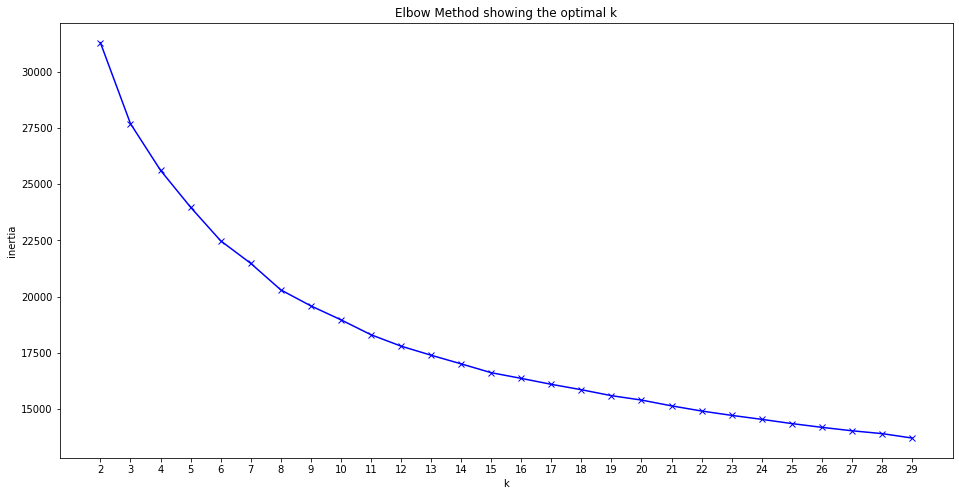

In [223]:
K = range(2, 30)
inertia = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=17)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

## Tune for Sillouette

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

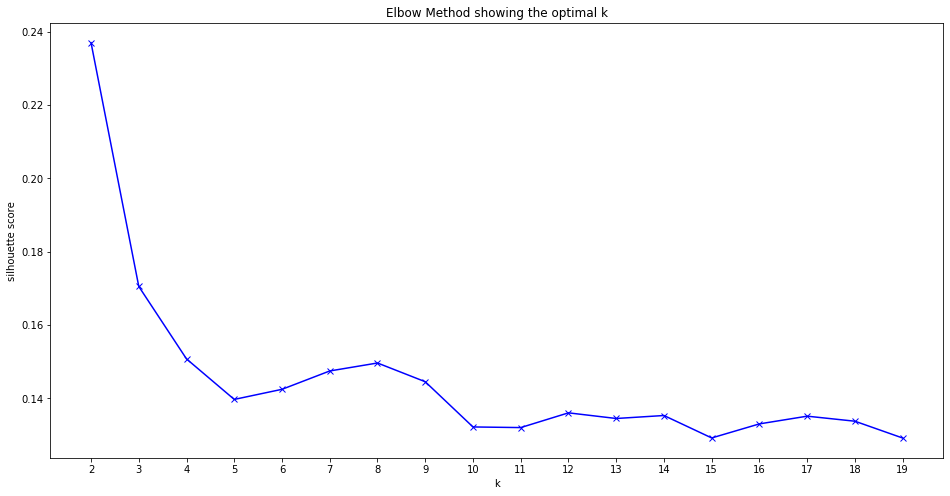

In [224]:
K = range(2, 20)
silhouette = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep,
                                       kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

### Visualising the Clusters

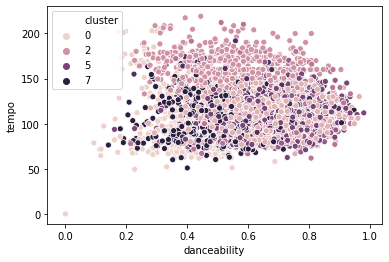

In [239]:
sns.scatterplot(data=X_df, x="danceability", y="tempo",hue='cluster')

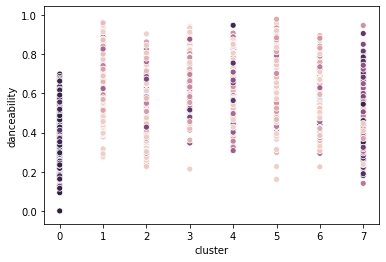

In [234]:
sns.scatterplot(data=X_df, x="cluster", y="danceability",hue='acousticness', legend=False)

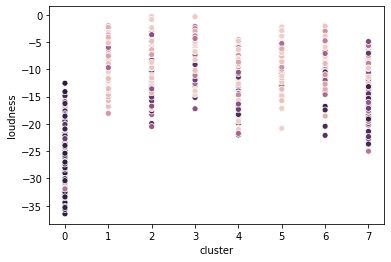

In [235]:
sns.scatterplot(data=X_df, x="cluster", y="loudness",hue='acousticness', legend=False)

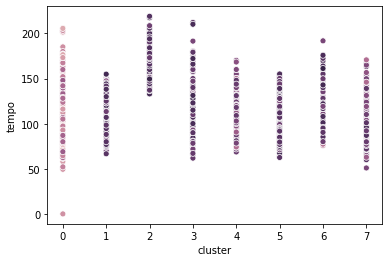

In [236]:
sns.scatterplot(data=X_df, x="cluster", y="tempo",hue='loudness', legend=False)

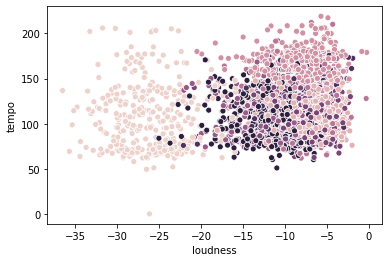

In [241]:
sns.scatterplot(data=X_df, x="loudness", y="tempo",hue='cluster', legend=False)

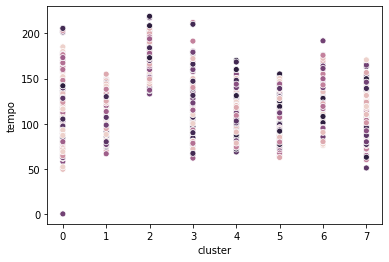

In [242]:
sns.scatterplot(data=X_df, x="cluster", y="tempo",hue='key', legend=False)

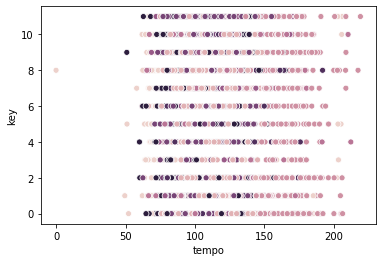

In [246]:
sns.scatterplot(data=X_df, x="tempo", y="key",hue='cluster', legend=False)

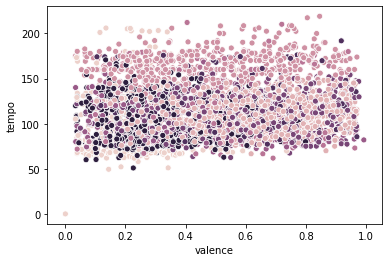

In [248]:
sns.scatterplot(data=X_df, x="valence", y="tempo",hue='cluster', legend=False)

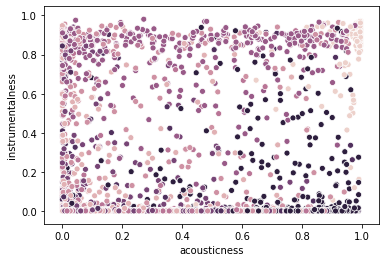

In [252]:
sns.scatterplot(data=X_df, x="acousticness", y="instrumentalness",hue='cluster', legend=False)

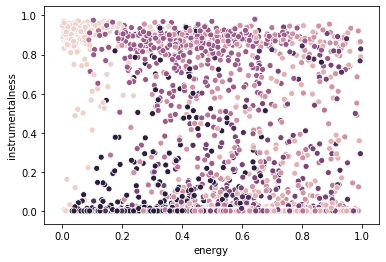

In [253]:
sns.scatterplot(data=X_df, x="energy", y="instrumentalness",hue='cluster', legend=False)

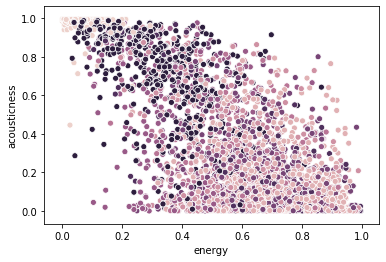

In [254]:
sns.scatterplot(data=X_df, x="energy", y="acousticness",hue='cluster', legend=False)